In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# to get deterministic output
#torch.manual_seed(123)

sys.path.append(os.path.abspath(".."))

### Hyperparameters

In [2]:
batch_size = 64
lr = 0.001
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DataLoader

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean & std of MNIST
])

train_dataset = datasets.MNIST(root="../datasets/mnist", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="../datasets/mnist", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

### Visualize the Dataset

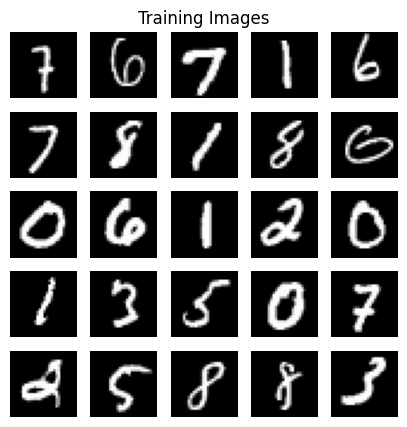

In [4]:
for images, _ in train_loader:  
    break

grid = images.view(-1, 28, 28).numpy()

plt.figure(figsize=(5,5))
plt.title("Training Images")
plt.axis("off")
for k in range(25):
    plt.subplot(5,5,k+1)
    plt.imshow(grid[k], cmap="gray")
    plt.axis("off")
plt.show()

### Define the Model

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)   # (in_channels, out_channels, kernel_size, stride)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)  # flatten after conv layers
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)      # -> (32, 26, 26)
        x = F.relu(x)
        x = self.conv2(x)      # -> (64, 24, 24)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # -> (64, 12, 12)
        x = self.dropout1(x)
        x = torch.flatten(x, 1) # flatten except batch
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Training Loop

In [6]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx/len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
          f"({accuracy:.2f}%)\n")

# -------------------------
# Run Training
# -------------------------
for epoch in range(epochs):
    train(model, device, train_loader, optimizer, epoch+1)
    test(model, device, test_loader)


Epoch: 1 [0/60000 (0%)]	Loss: 2.304682
Epoch: 1 [6400/60000 (11%)]	Loss: 0.271832
Epoch: 1 [12800/60000 (21%)]	Loss: 0.098137
Epoch: 1 [19200/60000 (32%)]	Loss: 0.090705
Epoch: 1 [25600/60000 (43%)]	Loss: 0.151359
Epoch: 1 [32000/60000 (53%)]	Loss: 0.055340
Epoch: 1 [38400/60000 (64%)]	Loss: 0.264072
Epoch: 1 [44800/60000 (75%)]	Loss: 0.073965
Epoch: 1 [51200/60000 (85%)]	Loss: 0.051790
Epoch: 1 [57600/60000 (96%)]	Loss: 0.046083

Test set: Average loss: 0.0433, Accuracy: 9845/10000 (98.45%)

Epoch: 2 [0/60000 (0%)]	Loss: 0.030189
Epoch: 2 [6400/60000 (11%)]	Loss: 0.264177
Epoch: 2 [12800/60000 (21%)]	Loss: 0.058264
Epoch: 2 [19200/60000 (32%)]	Loss: 0.056687
Epoch: 2 [25600/60000 (43%)]	Loss: 0.010064
Epoch: 2 [32000/60000 (53%)]	Loss: 0.115492
Epoch: 2 [38400/60000 (64%)]	Loss: 0.153400
Epoch: 2 [44800/60000 (75%)]	Loss: 0.051856
Epoch: 2 [51200/60000 (85%)]	Loss: 0.126694
Epoch: 2 [57600/60000 (96%)]	Loss: 0.059267

Test set: Average loss: 0.0365, Accuracy: 9883/10000 (98.83%)

Epoc